# Import darts

In [1]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.1 MB/s eta 0:00:0000:0100:01m


# Import the Darts module and other required libraries

In [33]:

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple ,Union
from pathlib import Path
import time
import os
import sys


from darts import TimeSeries
from darts.models import  RandomForest, LightGBMModel,TFTModel

from darts.metrics import mape, mse, ope, smape, marre, dtw_metric, mae,mase, rmse
from darts.utils.statistics import check_seasonality, plot_acf, extract_trend_and_seasonality
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

%matplotlib inline

In [3]:
#../input/repos-dataseta-raw-ds/raw_ds
project_dir = Path(r"../input/repos-dataseta-raw-ds/raw_ds")
project_dir

PosixPath('../input/repos-dataseta-raw-ds/raw_ds')

# dictionary of all repos ts file

In [4]:
# save individual repository paths to a dictionary
repos_dict = { ts.stem : ts for ts in project_dir.glob('*.csv') }
print(f"There are {len(repos_dict)} repository in the Dataset")

There are 596 repository in the Dataset


In [ ]:
# overview of the repos name and path
repos_dict

# Convert to Darts Timeseries object and split ts in target and past covariates series
*   The `commit_count` colum is the as target series. The `target time` series is the time series we are interested to forecast
*   `forks_count,Stars_count,pr_iss_Open_count,pr_iss_updated_count` and `pr_is_closed`_count are defiend as pass covariates series. A `covariate time` series is a time series which may help in the forecasting of the target series, but that we are not interested in forecasting. It’s sometimes also called external data.



In [6]:
# convert the initial time series into Dasts Timeseries object 
# split or create a target time-series which will be predicted
# und covariates, which are not going to be predicted 

def convert_ts_dts(
    repos_seqs: Union[List[str], Dict[str, Path]]
) -> Tuple[List[TimeSeries], List[TimeSeries]]:
    print("creating  sequences of TimeSeries from csv files...")

    # target timeseries sequences
    # pass covariate sequences
    target_ts_sqs, pass_covar_sqes = [], []
    for r_name, r_path in repos_seqs.items():
        target_series = TimeSeries.from_csv(
            r_path, time_col="date", value_cols="commit_count"
        )
        pass_covar = TimeSeries.from_csv(
            r_path,
            time_col="date",
            value_cols=[
                "forks_count",
                "Stars_count",
                "pr_iss_Open_count",
                "pr_iss_updated_count",
                "pr_is_closed_count",
            ],
        )

        target_ts_sqs.append(target_series.astype(np.float32))
        pass_covar_sqes.append(pass_covar.astype(np.float32))
    print(
        "Created. There are {} series, with average training length {}".format(
            len(target_ts_sqs), np.mean([len(s) for s in target_ts_sqs])
        )
    )
    return target_ts_sqs, pass_covar_sqes


In [7]:
target_ts, past_covar_ts = convert_ts_dts(repos_dict)

creating  sequences of TimeSeries from csv files...
Created. There are 596 series, with average training length 415.6677852348993


In [8]:
target_ts[0].dtype

dtype('float32')

# Create training and validation sets

In [9]:
def create_train_val_set(
    target_series: List[TimeSeries],
    pass_covariates: List[TimeSeries],
    test_size: float,
) -> Tuple[List[TimeSeries], List[TimeSeries], List[TimeSeries], List[TimeSeries]]:

    print("splitting train/test...")
    target_train = [s[:-test_size] for s in target_series]
    target_train_pass_covar = [s[:-test_size] for s in pass_covariates]

    target_test = [s[-test_size:] for s in target_series]
    target_test_pass_covar = [s[-test_size:] for s in pass_covariates]
    print("Split successfully completed...")
    return target_train, target_train_pass_covar, target_test, target_test_pass_covar


In [10]:
# the size of test set
test_size = 12  # weeks

(
    tar_train_ts,
    past_covar_train_ts,
    tar_test_ts,
    past_covar_test_ts,
) = create_train_val_set(target_ts, past_covar_ts, test_size)


splitting train/test...
Split successfully completed...


In [11]:
len(tar_train_ts) ,len(past_covar_train_ts), len(tar_test_ts), len(past_covar_test_ts)

(596, 596, 596, 596)

In [12]:
len(target_ts[0]), len(tar_train_ts[0]), len(tar_test_ts[0])

(90, 78, 12)

In [13]:
len(past_covar_ts[0]),len(past_covar_train_ts[0]),len(past_covar_test_ts[0])

(90, 78, 12)

# scale the train and test Ts as well as the Covariates (0-1)
Neural networks are sensitive to variations in magnitude. Therefore, we need to scale the original timeseries. the scaler fits to the training dataset. To preclude leakage, we do not fit the scaler to the test set. 

In [14]:
# Scale to between (0,1)
def scale_train_val_set(
    target_series: List[TimeSeries],
    pass_covariates: List[TimeSeries],
    test_size: int,
) -> Tuple[
    List[TimeSeries],
    List[TimeSeries],
    List[TimeSeries],
    List[TimeSeries],
    List[TimeSeries],
    List[TimeSeries],
]:

    scaler_taget = Scaler()
    scaler_cavar = Scaler()

    print("Scaling of time series sequence...")
    tts_train_trans = [scaler_taget.fit_transform(s[:-test_size]) for s in target_series]
    tts_train_pcor_trans = [scaler_cavar.fit_transform(s[:-test_size]) for s in pass_covariates]

    tts_test_trans = [scaler_taget.transform(s[-test_size:]) for s in target_series]
    tts_test_pcor = [scaler_cavar.transform(s[-test_size:]) for s in pass_covariates]
    # Transform the target and the covariant time series sequences
    tseries_trans = [scaler_taget.transform(s) for s in target_series]
    ts_pcor_trans = [scaler_cavar.transform(s) for s in pass_covariates]

    print("Scaling successfully completed...")
    return (
        tts_train_trans,
        tts_train_pcor_trans,
        tts_test_trans,
        tts_test_pcor,
        tseries_trans,
        ts_pcor_trans,
        scaler_taget
        )

In [15]:
# the size of test set
test_size = 12  # weeks

(
    tts_train_trans,
    pcts_train_trans,
    tts_test_trans,
    pcts_test_trans,
    tseries_trans,
    pcor_trans,
    transformer,
) = scale_train_val_set(target_ts, past_covar_ts, test_size)



Scaling of time series sequence...
Scaling successfully completed...


In [16]:
type(tts_train_trans[0].dtype)


numpy.dtype[float32]

In [17]:
len(tts_train_trans), len(pcts_train_trans), len(tts_test_trans), len(pcts_test_trans), len(tseries_trans), len(pcor_trans)

(596, 596, 596, 596, 596, 596)

# Models

## Helper functions for the evaluation

In [18]:
import time
t_start1 = time.perf_counter()
FIGSIZE =(9,6)

In [34]:
def eval_forecasts(
    pred_series: List[TimeSeries], test_series: List[TimeSeries]
) -> List[float]:

    print("computing RMSEs...")
    maes = mae(test_series, pred_series)
    mses = mse(test_series, pred_series)
    rmses = rmse(test_series, pred_series)
    plt.figure()
    plt.hist(maes, bins=50)
    plt.ylabel("Count")
    plt.xlabel("RMSE")
    plt.title("Median RMSEs: %.3f" % np.median(rmses))
    plt.show()
    plt.close()
    res_accuracy = {
        "MAE": np.median(maes),
        "MSE": np.median(mses),
        "RMSE": np.median(rmses),
    }
    return res_accuracy

In [35]:
def eval_global_model(
    train_series: List[TimeSeries],
    train_pass_covars: List[TimeSeries],
    val_series: List[TimeSeries],
    val_pass_covars: List[TimeSeries], 
    model_cls, 
    **kwargs
) -> Tuple[List[float],List[float],List[float], float]:

    start_time = time.time()

    model = model_cls(**kwargs)
    print("beginning: " + str(model))
    model.fit(train_series,
              past_covariates = train_pass_covars )
    
    preds = model.predict(n=PRED_LEN, series=train_series, 
                          past_covariates = train_pass_covars)

    elapsed_time = time.time() - start_time

    smapes = eval_forecasts(preds, val_series)
    return smapes, preds, model ,elapsed_time 

In [36]:
def plot_predict(actual_ts, ts_test, pred_ts , num_ts):
    
    figure, ax = plt.subplots(3, 2, figsize=(15, 10), dpi=100, )
    plt.subplots_adjust(
            left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.50,
            )
    ax = ax.ravel()
    
    figure.suptitle('Vorhersage für den Test Datenset')
    ## plot time series, limited to forecast horizon
    #plt.figure(figsize=FIGSIZE)
    for idx in range(num_ts):
        pred_invts = transformer.inverse_transform(pred_ts[idx])
        # Plot actual
        actual_ts[idx][-24:].plot(label="Actual Timeseries", ax=ax[idx])
        
        # plot prediction 
        pred_invts.plot( label="Predicted Timeseries", color="green", ax=ax[idx])
        ax[idx].set_title("Test set (RMSE: {:.2f})".format(rmse(ts_test[idx], pred_invts)))
        ax[idx].set_xlabel("Datetime")
        ax[idx].set_ylabel("Anzahl der Aktivitäten")
        ax[idx].legend()



In [75]:
def plot_future(actual_ts, ts_test, pred_ts , num_ts):
    
    figure, ax = plt.subplots(3, 2, figsize=(15, 10), dpi=100, )
    plt.subplots_adjust(
            left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.50,
            )
    ax = ax.ravel()
    
    figure.suptitle('Vorhersage für den Test Datenset')

    for idx in range(num_ts):
        pred_invts = transformer.inverse_transform(pred_ts[idx])
        
        # Plot actual
        actual_ts[idx][-24:].plot(label="Actual Timeseries", ax=ax[idx])
        
        # plot prediction 
        pred_invts.plot( label="Predicted Timeseries", color="green", ax=ax[idx])
        ax[idx].set_xlabel("Datetime")
        ax[idx].set_ylabel("Anzahl der Aktivitäten")
        ax[idx].legend()

# Models: Regression Model

In [78]:
# constants
LAG = 18   #34-16
OUT_LEN = 12
LAG_COVAR =18
PRED_LEN = 12


beginning: RandomForest(lags={'target': [-18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1], 'past': [-18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]}, n_estimators=1000, max_depth=3)
computing RMSEs...


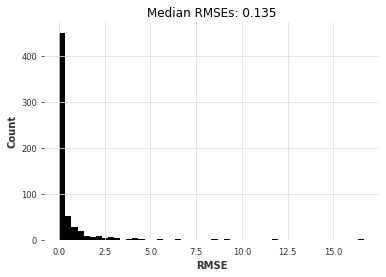

In [79]:
# Definition of the model and fit 
rf_result,rf_pred,rf_model, rf_time  = eval_global_model(
    tts_train_trans,
    pcts_train_trans,
    tts_test_trans,
    pcts_test_trans,
    RandomForest, 
    lags=LAG,  
    output_chunk_length=OUT_LEN, 
    lags_past_covariates=LAG_COVAR,
    n_estimators = 1000, #The number of trees in the forest. 
    max_depth= 3,
    n_jobs = 3 
   
)

In [82]:
rf_result

{'MAE': 0.09814942084990019,
 'MSE': 0.018242249310272636,
 'RMSE': 0.13506166494604124}

In [84]:
print(f"Random Forest time : {int(rf_time /60)} Minutes")

Random Forest time : 45 Minutes


In [87]:
rf_prediction = {
    "Random Forest": rf_result,
}

In [90]:
df_acc = pd.DataFrame.from_dict(rf_prediction, orient="index")
pd.set_option("display.precision",4)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="lightblue", axis=1)

,MAE,MSE,RMSE
Random Forest,0.0981,0.0182,0.1351


# Test the prediction on the test data set and compare it to the actual data,to see if the model correctly predicts the test data set or not

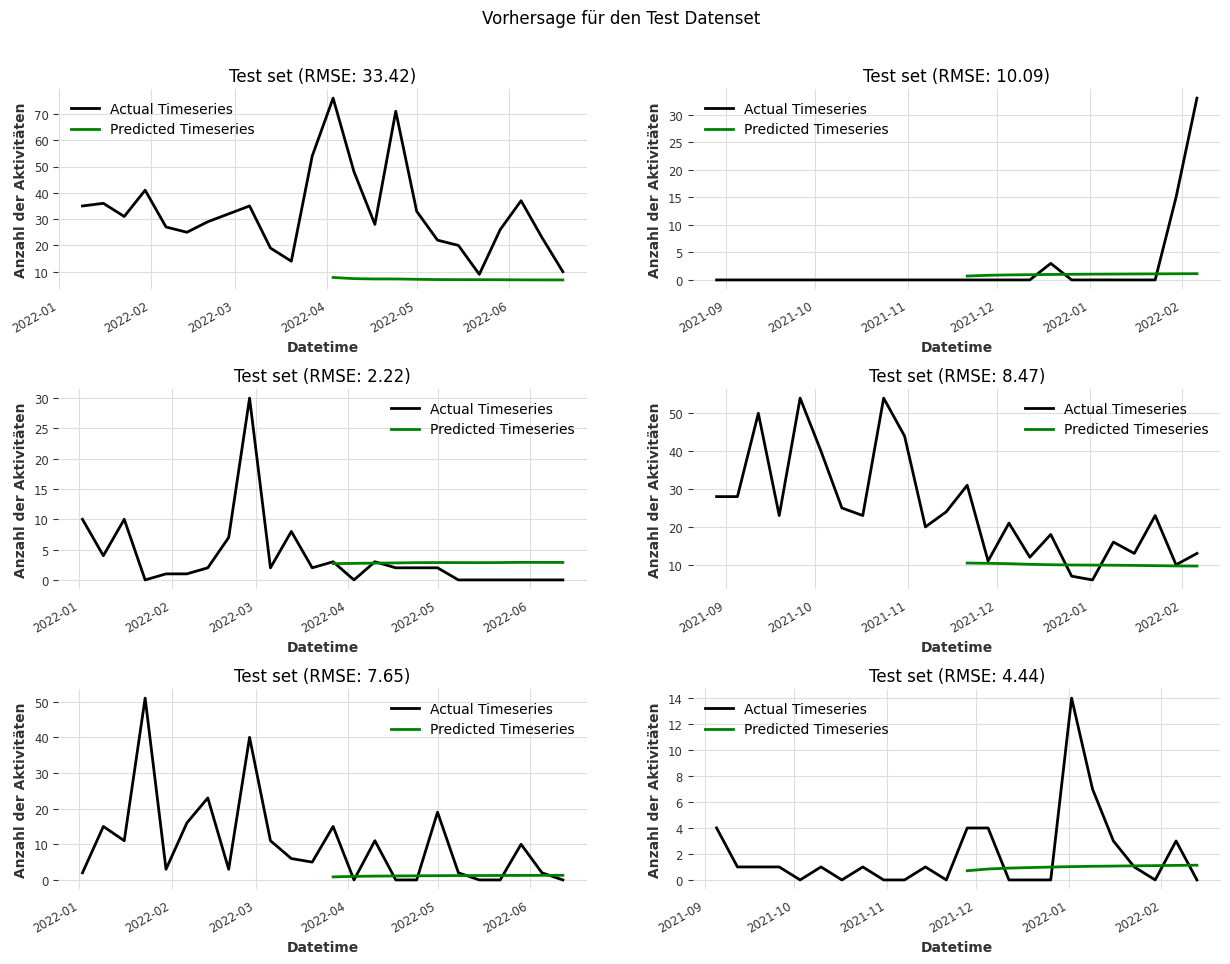

In [91]:
plot_predict(target_ts, tar_test_ts, rf_pred , 6)

# Autual future prediction 

In [92]:
# Actual future predition 
ef_preds_futu = rf_model.predict(n=PRED_LEN,
                                series = tseries_trans,
                                past_covariates =  pcor_trans,
                                num_samples=1 #Deterministic Forecast
                            )

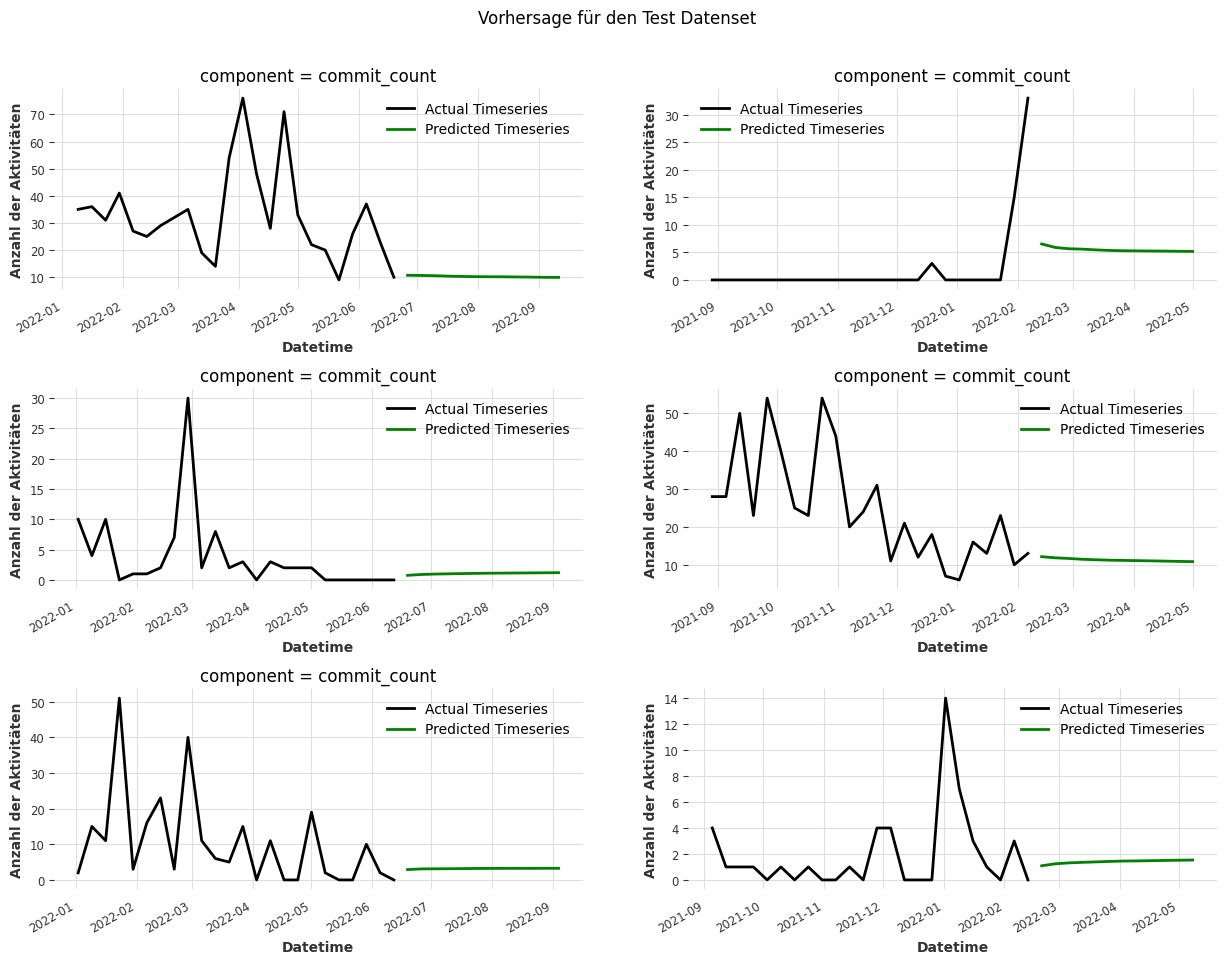

In [93]:
plot_future(target_ts, tseries_trans, ef_preds_futu , 6)

# Model: TFT

In [22]:
log_file = Path( Path.cwd()/"models")

log_file.mkdir(parents=True, exist_ok=True)
log_file

PosixPath('/kaggle/working/models')

In [26]:

LOAD = False         # True = load previously saved model from disk?  False = (re)train the model
SAVE =  "/_TFT_model.pth.tar"   # file name to save the model under

EPOCHS = 5 #100     # Number of Epochs
INPUT_LEN =18       # input size = input_chunk_length
OUT_LEN = 12        # output size = output_chunk_length
HIDDEN = 32         # hidden layers    
LSTMLAYERS = 2      # recurrent layers
ATTH = 4            # attention heads
BATCH = 32          # batch size
LEARN = 1e-3        # learning rate
DROPOUT = 0.1       # dropout rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
PRED_LEN = 12       # Forecasting horizon

RAND = 42           # random seed
N_SAMPLES = 1       # number of times a prediction is sampled from a #Deterministic Forecast
N_JOBS = 3          # parallel processors to use;  -1 = all processors


FIGSIZE = (9, 6)

mpath = os.path.abspath(str(Path.cwd()/ log_file)) + SAVE  # path and file name to save the model 

In [29]:
# Definition of the model
model = TFTModel(   input_chunk_length=INPUT_LEN,
                    output_chunk_length=OUT_LEN,
                    hidden_size=HIDDEN,
                    lstm_layers=LSTMLAYERS,
                    num_attention_heads=ATTH,
                    dropout=DROPOUT,
                    batch_size=BATCH,
                    n_epochs=EPOCHS,                        
                    nr_epochs_val_period=VALWAIT, 
                    likelihood=None, 
                    loss_fn=torch.nn.MSELoss(), 
                    optimizer_kwargs={"lr": LEARN}, 
                    add_encoders={'cyclic': {'future': ['month']},
                                'datetime_attribute': {'future': ['hour', 'dayofweek']}},
                    add_relative_index=False,
                    work_dir = log_file,
                    model_name="TFT_Model",
                    log_tensorboard=True,
                    random_state=RAND,
                    force_reset=True,
                    pl_trainer_kwargs={
                        "accelerator": "gpu",
                          "gpus": int(torch.cuda.is_available())
                    },

                    save_checkpoints=True
                )

In [30]:
!nvidia-smi

Sat Aug  6 13:31:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
# training: load a saved model or (re)train
# training: load a saved model or (re)train
if LOAD:
    print("have loaded a previously saved model from disk:" + mpath)
    model = TFTModel.load_model(mpath)  # load previously model from disk 
else:
    start_time = time.time()
    model.fit( tts_train_trans, past_covariates=pcts_train_trans, verbose=True)
    print("have saved the model after training:", mpath)
    model.save_model(mpath)
    elapsed_time = time.time() - start_time
    

Training: 0it [00:00, ?it/s]

have saved the model after training: /kaggle/working/models/_TFT_model.pth.tar


In [32]:
pred_series = model.predict(n=PRED_LEN,
                                series = tts_train_trans,
                                past_covariates = pcts_train_trans,
                                num_samples=1 #Deterministic Forecast
                            )

Predicting: 50046it [00:00, ?it/s]

computing RMSEs...


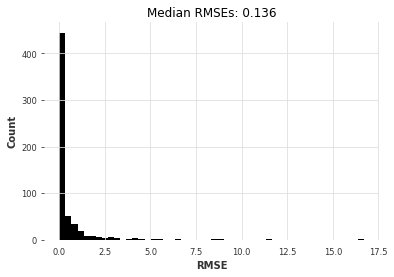

In [37]:
tft_result = eval_forecasts(pred_series, tts_test_trans)

In [72]:
tft_result

{'MAE': 0.095613286, 'MSE': 0.018465405, 'RMSE': 0.13588743}

In [96]:
print(f"Random Forest time : {int(elapsed_time / 60)} Minutes")

Random Forest time : 334 Minutes


In [38]:
len(pred_series)

596

In [43]:
model_predictions = {
    "TFTModel": tft_result,
}

In [74]:
df_acc = pd.DataFrame.from_dict(model_predictions, orient="index")
pd.set_option("display.precision",4)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="lightblue", axis=1)

,MAE,MSE,RMSE
TFTModel,0.0956,0.0185,0.1359


# Test the prediction on the test data set and compare it to the actual data, to see if the model correctly predicts the test data set or not

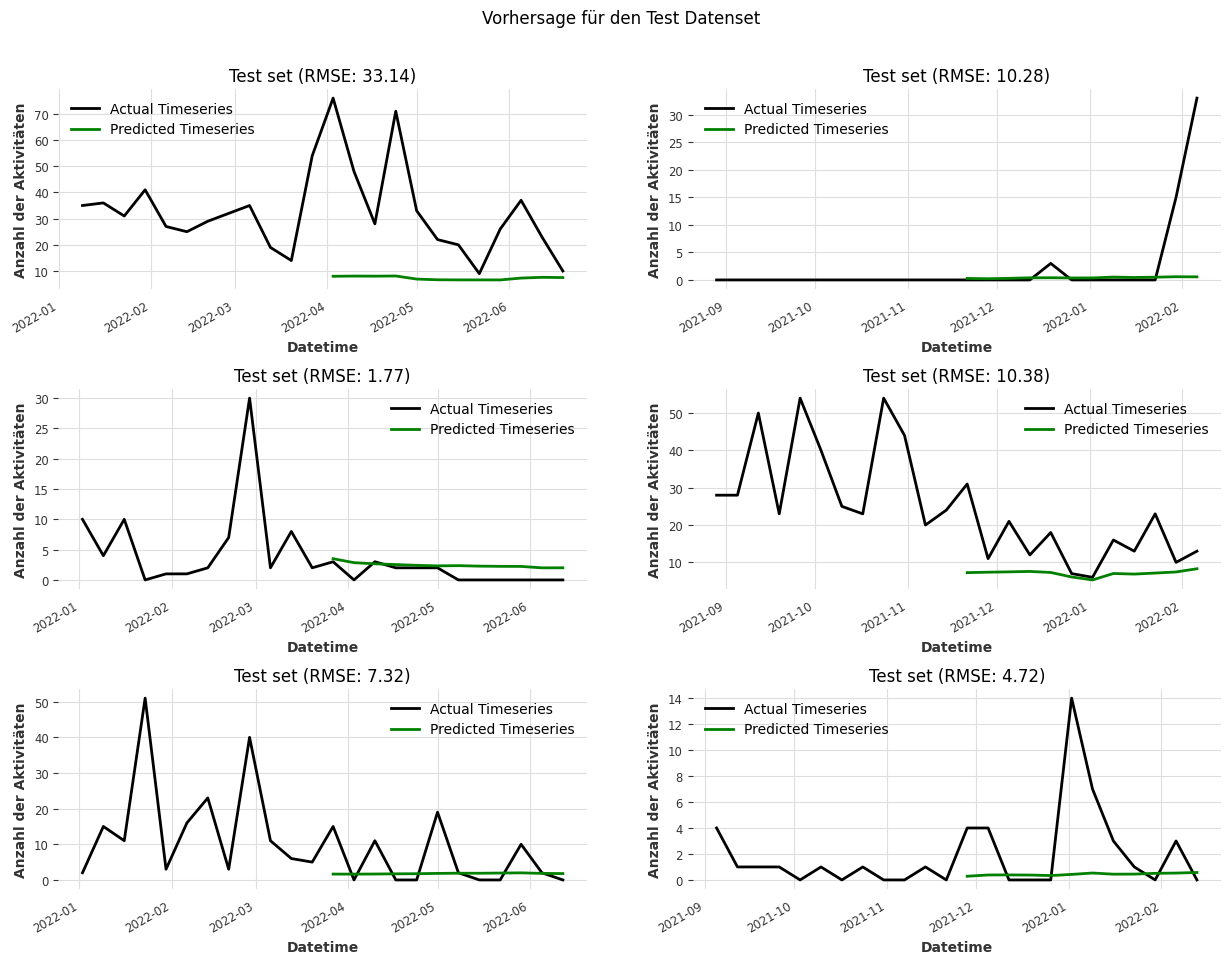

In [45]:
plot_predict(target_ts, tar_test_ts, pred_series , 6)

# Actual predition 

In [81]:
tft_pred_future = model.predict(n=PRED_LEN,
                                series = tseries_trans,
                                past_covariates =  pcor_trans,
                                num_samples=1 #Deterministic Forecast
                            )

Predicting: 50046it [00:00, ?it/s]

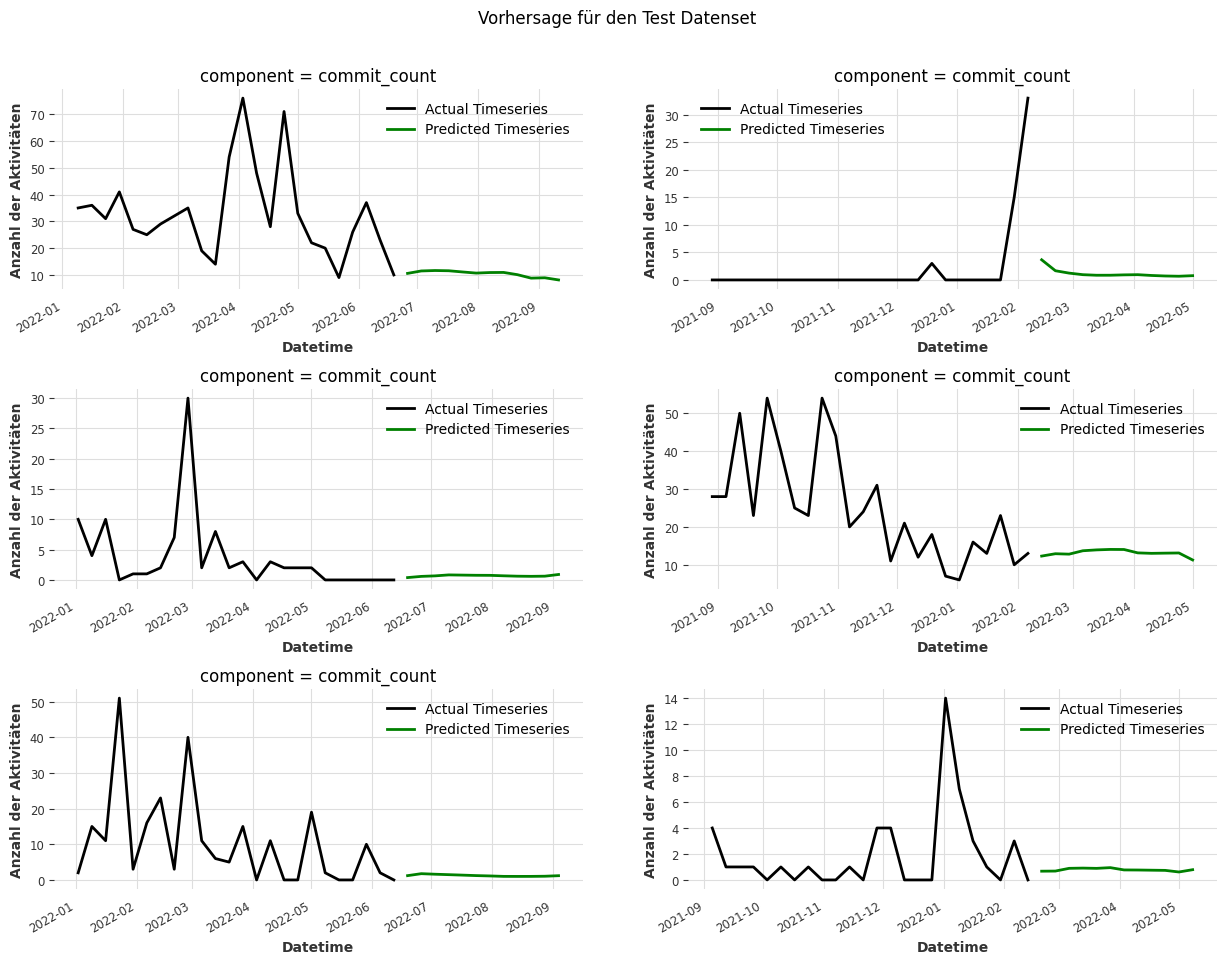

In [76]:
plot_future(target_ts, tseries_trans, tft_pred_future , 6)

# Both models result

In [94]:
models_results = {
    "Random Forest": rf_result,
    "TFTModel": tft_result
}

df_acc = pd.DataFrame.from_dict(models_results, orient="index")
pd.set_option("display.precision",4)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="lightblue", axis=1)

,MAE,MSE,RMSE
Random Forest,0.0981,0.0182,0.1351
TFTModel,0.0956,0.0185,0.1359


# 